In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Colab_Notebooks/perturbation_metric_test
!pip install anndata
#!pip install git+https://github.com/theislab/scgen.git
!pip install scgen==2.0.0
!pip install matplotlib
!pip install scanpy
!pip install pertpy

Mounted at /content/drive
/content/drive/MyDrive/Colab_Notebooks/perturbation_metric_test
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.0/351.0 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.5/732.5 kB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:

!pip install -U jax jaxlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 MB 8.8 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.10+cuda11.cudnn86
    Uninstalling jaxlib-0.4.10+cuda11.cudnn86:
      Successfully uninstalled jaxlib-0.4.10+cuda11.cudnn86


In [ ]:
import anndata
import scanpy as sc

import pandas as pd
import numpy as np
import pertpy as pt
import matplotlib.pyplot as plt
import seaborn as sns

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.


To use sccoda or tasccoda please install ete3 with pip install ete3

In [ ]:
!ls

%cd drive/MyDrive/Colab_Notebooks/perturbation_metric_test

drive  sample_data
/content/drive/MyDrive/Colab_Notebooks/perturbation_metric_test


In [ ]:
train = sc.read("./data/PapalexiSatija2021_eccite_RNA.h5ad")
sc.pp.normalize_total(train, target_sum=1e4)
sc.pp.log1p(train)
sc.pp.highly_variable_genes(train, n_top_genes=100, subset=True, min_mean=.1)
sc.pp.pca(train, use_highly_variable=True)
train.obs['exp1']=train.obs['perturbation']

In [ ]:
control=train[train.obs['perturbation']=='control']
def sample(train,control):
  sample = control.obs.groupby("perturbation").apply(lambda x: x.sample(frac=1,replace=False))# no random state, shuffle
  name=[]
  # print(sample)
  for _,i in sample.index:
    name.append(i)
  new=control[control.obs_names.isin(name)]

  n=new.shape[0]//5
  # print(new,n)
  sub=[]
  # sub=np.split(new,5,0)
  for i in range(5):#subset0:10,10:20,20:30,30:40,40:50
    sub.append(new[i*n:(i+1)*n,:])
    sub[i].obs['exp1']='control'+ str(i+1) #label the subset
    sub[i].obs['perturbation']='control'+ str(i+1)#set up perturbation for ctrl sample
    # new=new[:(i+1)*n+1,:]# ???

  print(sub)

  merge=train.copy()

  for data in sub:#merge subset with original data
    merge=anndata.concat([merge,data], join="outer")
    # print(merge)
  # print(sub)


  return merge

merge=sample(train,control)
print(merge)
merge.obs

[AnnData object with n_obs × n_vars = 477 × 100
    obs: 'hto', 'guide_id', 'hto_barcode', 'gdo_barcode', 'perturbation', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'exp1'
    var: 'ensembl_id', 'ncounts', 'ncells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs', AnnData object with n_obs × n_vars = 477 × 100
    obs: 'hto', 'guide_id', 'hto_barcode', 'gdo_barcode', 'perturbation', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'exp1'
    var: 'ensembl_id', 'ncounts', 'ncells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs', AnnData object with n_obs × n_vars = 477 × 100
    obs: 'hto', 'guide_id', 'hto_barco

,hto,guide_id,hto_barcode,gdo_barcode,perturbation,tissue_type,cell_line,cancer,disease,perturbation_type,celltype,organism,nperts,ngenes,ncounts,percent_mito,percent_ribo,exp1
AAACCTGAGCCAGAAC,rep1-tx,STAT2g2,AGGACCATCCAA,CTTCGTGTACGGTTGCACA,STAT2g2,cell_line,THP-1,True,acute monocytic leukemia,CRISPR,monocytes,human,1,3942,17207.0,2.295577,14.714942,STAT2g2
AAACCTGAGTGGACGT,rep1-tx,CAV1g4,AGGACCATCCAA,GTCTACGTATTTGCCCCCA,CAV1g4,cell_line,THP-1,True,acute monocytic leukemia,CRISPR,monocytes,human,1,2948,9506.0,4.512939,9.877972,CAV1g4
AAACCTGCATGAGCGA,rep1-tx,STAT1g2,AGGACCATCCAA,CATCCTTTGGTACAACATG,STAT1g2,cell_line,THP-1,True,acute monocytic leukemia,CRISPR,monocytes,human,1,4258,15256.0,4.116413,13.227583,STAT1g2
AAACCTGTCTTGTCAT,rep1-tx,CD86g1,AGGACCATCCAA,ATTCCTTGGATTACAGCTG,CD86g1,cell_line,THP-1,True,acute monocytic leukemia,CRISPR,monocytes,human,1,1780,5135.0,5.491723,21.888997,CD86g1
AAACGGGAGAACAACT,rep1-tx,IRF7g2,AGGACCATCCAA,CCAGTACACCTTGCACTTG,IRF7g2,cell_line,THP-1,True,acute monocytic leukemia,CRISPR,monocytes,human,1,2671,9673.0,3.359868,13.263724,IRF7g2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCCTCCAAGACACG,rep3-tx,NTg7,AGGACCATCCAA,GCCGTTAAGCGGAAACGAT,control5,cell_line,THP-1,True,acute monocytic leukemia,CRISPR,monocytes,human,0,2256,6869.0,3.362935,18.183142,control5
TTTCCTCTCAGCAACT,rep3-tx,NTg2,AGGACCATCCAA,ATAAACACTATACCATGTA,control5,cell_line,THP-1,True,acute monocytic leukemia,CRISPR,monocytes,human,0,4298,16790.0,3.323407,11.560453,control5
TTTGGTTGTTCCTCCA,rep4-tx,NTg5,TCGATAATGCGA,TGAACGGGCCGCGGAAGCG,control5,cell_line,THP-1,True,acute monocytic leukemia,CRISPR,monocytes,human,0,1756,5093.0,5.262124,18.574514,control5
TTTGGTTTCGACCAGC,rep4-tx,NTg9,TCGATAATGCGA,ATGTCTCGCCCCGATATGG,control5,cell_line,THP-1,True,acute monocytic leukemia,CRISPR,monocytes,human,0,2302,5837.0,5.105362,18.125750,control5


In [ ]:
train=merge
train.obs['perturbation'].unique()

array(['STAT2g2', 'CAV1g4', 'STAT1g2', 'CD86g1', 'IRF7g2', 'control',
       'ATF2g4', 'STAT3g4', 'JAK2g2', 'NFKBIAg1', 'CAV1g1', 'SMAD4g1',
       'STAT5Ag2', 'CMTM6g2', 'JAK2g3', 'ATF2g2', 'CMTM6g3', 'STAT5Ag3',
       'IFNGR1g4', 'UBE2L6g2', 'CD86g4', 'PDCD1LG2g1', 'CUL3g1', 'BRD4g4',
       'MARCH8g2', 'IRF1g2', 'POU2F2g1', 'BRD4g3', 'MARCH8g3', 'IFNGR1g2',
       'ETV7g3', 'UBE2L6g1', 'IFNGR1g3', 'ETV7g1', 'IRF1g1', 'CD86g2',
       'IRF1g4', 'STAT3g3', 'IFNGR2g2', 'PDCD1LG2g3', 'ETV7g2', 'CMTM6g1',
       'PDCD1LG2g4', 'STAT1g3', 'CAV1g3', 'MARCH8g1', 'IFNGR2g4',
       'NFKBIAg2', 'MARCH8g4', 'IFNGR2g1', 'STAT5Ag1', 'NFKBIAg3',
       'JAK2g1', 'IRF7g3', 'TNFRSF14g2', 'STAT3g1', 'IFNGR2g3',
       'STAT5Ag4', 'IRF7g1', 'BRD4g2', 'ATF2g1', 'CD86g3', 'IRF1g3',
       'TNFRSF14g3', 'POU2F2g3', 'STAT2g3', 'SMAD4g4', 'ETV7g4',
       'SMAD4g2', 'CUL3g2', 'CAV1g2', 'TNFRSF14g1', 'SPI1g4', 'STAT1g1',
       'JAK2g4', 'MYCg3', 'MYCg1', 'STAT3g2', 'SMAD4g3', 'UBE2L6g3',
       'IFNGR1g1'

In [ ]:
def filter_ncell(ncell, train,max):
  """
  ncell: the condi for experiment1
  train: anndata dataset
  output: new anndata dataset
  """
  #each perturbation left with 500 cells, and we subsample it to 100
  groups=train.obs.groupby("perturbation").apply(lambda x: x.sample(n=ncell, random_state=1,replace=False))
  name=[]
  for _,i in groups.index:
    name.append(i)
  new=train[train.obs_names.isin(name)]
  return new

def generate(cond,train):
  max=np.max(cond)
  adata=[]
  #we filter out perturbation which has cells less than 500
  train=train[train.obs['perturbation'].map(train.obs['perturbation'].value_counts()) >= max]
  for ncell in cond:
    adata.append(filter_ncell(ncell,train,max))
  return adata
condi = [100,200,300,400]
adata=generate(condi,train)
adata[0]

View of AnnData object with n_obs × n_vars = 1550 × 100
    obs: 'hto', 'guide_id', 'hto_barcode', 'gdo_barcode', 'perturbation', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'exp1'
    obsm: 'X_pca'

In [ ]:
condi = list([100,200,300])
metrics=list(["edistance",'pseudobulk','wasserstein','mmd'])


res_dict={"res":[],"metric":[],"condi":[]};

data=generate(condi,train) #should return 3 dataset

for metric in metrics:
  for i, ncell in enumerate(condi):
    adata=data[i]# don't reuse
    # adata=filter_ncell(ncell,train)# generate single dataset according to the ncell

    distance=pt.tools.Distance(metric=metric)
    pairwise_df = distance.pairwise(adata, groupby='perturbation')
    display(pairwise_df)
    ctrl_ctrl=pairwise_df.loc[['control1','control2','control3','control4','control5'],['control1','control2','control3','control4','control5']]
    ctrl=np.sum(np.sum(ctrl_ctrl))/(25-5) #get distance control to control (exclude the diagonal elements)
    print("control: ",ctrl, "metric:",metric,"ncell:",ncell)

    ctrl_stim=pairwise_df.loc[['control1','control2','control3','control4','control5'],:]
    ctrl_stim.drop(['control1','control2','control3','control4','control5','control'],axis=1)
    res=np.mean(ctrl_stim,1)#-ctrl # distance of control to stim

    for i in range(len(res)):#each result we should now its metric and condi
      res_dict["res"].append(res[i])
      res_dict["metric"].append(metric)
      res_dict["condi"].append(ncell)

    #we create a data frame that show difference between metruics measurements between (ctrl,ctrl) and (ctrl,stim) over the condition on how many cells sampled
    # res_dict["res"].append(res)
    # res_dict["metric"].append(metric)
    # res_dict["condi"].append(ncell)


df=pd.DataFrame.from_dict(res_dict)
df

Working... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

perturbation,CD86g1,control,JAK2g2,CMTM6g3,CD86g4,POU2F2g1,IFNGR1g2,IFNGR1g3,IRF1g4,IFNGR2g2,...,IFNGR2g1,IRF7g1,ATF2g1,TNFRSF14g3,TNFRSF14g1,control1,control2,control3,control4,control5
perturbation,,,,,,,,,,,,,,,,,,,,,
CD86g1,0.000000,0.033708,0.423798,0.048715,0.081923,0.109537,0.186207,0.542203,1.247786,0.333552,...,0.613904,0.070336,0.060265,0.052487,0.038112,0.459500,0.491664,0.170200,0.201873,0.184741
control,0.033708,0.000000,0.406121,0.053457,0.077645,0.090718,0.160304,0.540015,1.342553,0.336661,...,0.615358,0.067718,0.038115,0.029866,0.039827,0.380034,0.428617,0.160067,0.194002,0.175016
JAK2g2,0.423798,0.406121,0.000000,0.426704,0.491909,0.500227,0.115239,0.086393,1.755610,0.074242,...,0.065765,0.565696,0.533130,0.447407,0.394389,0.944012,1.023308,0.452533,0.475687,0.480260
CMTM6g3,0.048715,0.053457,0.426704,0.000000,0.056630,0.076740,0.173720,0.565200,1.130134,0.337656,...,0.613881,0.038308,0.096190,0.067798,0.040086,0.380906,0.399545,0.263381,0.281816,0.276919
CD86g4,0.081923,0.077645,0.491909,0.056630,0.000000,0.061971,0.188303,0.650019,1.109854,0.409478,...,0.691324,0.040843,0.094723,0.101945,0.074191,0.217453,0.227654,0.405040,0.444616,0.420315
POU2F2g1,0.109537,0.090718,0.500227,0.076740,0.061971,0.000000,0.225509,0.675059,1.141272,0.394324,...,0.695019,0.080530,0.101753,0.093177,0.087514,0.206897,0.279011,0.406872,0.450761,0.436954
IFNGR1g2,0.186207,0.160304,0.115239,0.173720,0.188303,0.225509,0.000000,0.223830,1.393348,0.115255,...,0.239066,0.229390,0.243732,0.191116,0.169367,0.511803,0.563750,0.344819,0.368455,0.349381
IFNGR1g3,0.542203,0.540015,0.086393,0.565200,0.650019,0.675059,0.223830,0.000000,1.907344,0.103007,...,0.051665,0.715141,0.677433,0.573177,0.543132,1.196697,1.314712,0.507020,0.510848,0.521900
IRF1g4,1.247786,1.342553,1.755610,1.130134,1.109854,1.141272,1.393348,1.907344,0.000000,1.572148,...,1.929437,1.075949,1.357632,1.365881,1.137979,1.301412,1.344096,1.816607,1.818867,1.751596


control:  0.6687962591648102 metric: mmd ncell: 300


,res,metric,condi
0,0.192860,edistance,100
1,0.246955,edistance,100
2,0.173117,edistance,100
3,0.180938,edistance,100
4,0.168682,edistance,100
5,0.161419,edistance,200
6,0.168983,edistance,200
7,0.119064,edistance,200
8,0.121022,edistance,200
9,0.142623,edistance,200


<Axes: xlabel='condi', ylabel='res'>

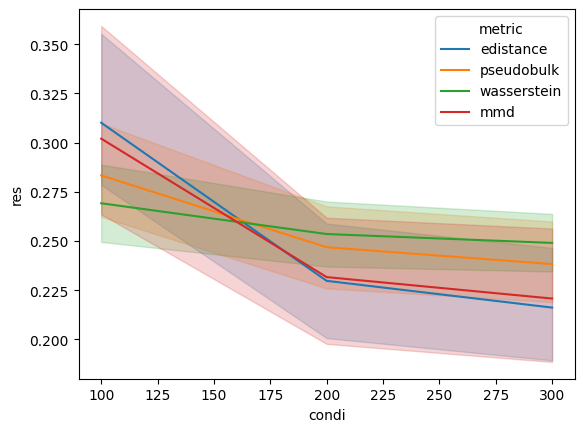

In [ ]:
import itertools
import seaborn as sns

def normalize_2d(matrix):
  """
  matrix: df colum we want to normalize
  output: the normalized column, sum all float entries equal 1
  """
  norm = np.linalg.norm(matrix)
  matrix = matrix/norm  # normalized matrix
  return matrix


metrics=list(["edistance",'pseudobulk','wasserstein','mmd'])
res2=[]
for m in metrics:
  new=df[df['metric']==m]
  res2.append(list(normalize_2d(new['res'])))


flat_res = [item for sublist in res2 for item in sublist]
df.loc[:,['res']]=flat_res

sns.lineplot(data=df, x="condi", y="res", hue="metric")